In [1]:
import model_function as mf

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pandas as pd
import psycopg2 as pg2

In [3]:
df = pd.read_csv('/data/npi_2013_clean1.csv')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
df[df['npi']==1477571818].T

,9342
Unnamed: 0,14959
npi,1477571818
last_name,ALAM
first_name,WASEEM
entity_code,I
provider_zip,483025051
provider_city,BLOOMFIELD HILLS
specialty_desc,Internal Medicine
bene_count,575
total_claim_count,21827


In [4]:
X_train, X_test = mf.make_train_test_dataset(df)

In [5]:
keep_cols = ['bene_count'
             , 'total_claim_count'
             , 'total_drug_cost'
             , 'total_day_supply'
             , 'brand_claim_count'
             , 'brand_claim_cost'
             , 'generic_claim_count'
             , 'generic_claim_cost'
             , 'other_claim_count'
             , 'other_claim_cost'
             , 'mapd_claim_count'
             , 'mapd_claim_cost'
             , 'pdp_claim_count'
             , 'pdp_claim_cost'
             , 'lis_claim_count'
             , 'lis_claim_cost'
             , 'nonlis_claim_count'
             , 'nonlis_claim_cost'
            ]

In [6]:
mod_if = mf.fit_model(X_train, keep_cols)

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   40.2s finished


In [7]:
conn = pg2.connect(dbname='medicare', user='postgres')
query = '''
        SELECT n.npi
            , indict.first_name
            , indict.last_name
            , indict.npi_status
            , indict.year_start
            , indict.year_end
        FROM indictments_2013 indict
            , npi_name n
        WHERE lower(indict.first_name) = lower(n.providerfirstname)
        AND lower(indict.last_name) = lower(n.providerlastnamelegalname)
        ;
        '''

In [8]:
# Tried running npi match with state as well (first name, last name, state), 
# but it really restricts the data set. Look into this.
# Lot more npi's, but maybe they're not really indicted?
# Might throw off validation

In [9]:
df_labels = pd.read_sql_query(query, conn)

In [10]:
test_df = mf.prediction(X_test, keep_cols, mod_if)

model_function.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['prediction'] = model.predict(test_df[model_columns])


In [11]:
test_df = mf.check_labels(df_labels, test_df, keep_cols)

model_function.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  else 0 for row in test_df['npi']]


In [35]:
test_df[test_df['npi']==1477571818]

,Unnamed: 0,npi,last_name,first_name,entity_code,provider_zip,provider_city,specialty_desc,bene_count,total_claim_count,...,nonlis_claim_cost,brand_claim_cost_avg,generic_claim_cost_avg,other_claim_cost_avg,mapd_claim_cost_avg,pdp_claim_cost_avg,lis_claim_cost_avg,nonlis_claim_cost_avg,prediction,indicted


### PCA/Graph to visualize data

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import plotly.tools as tls


#### Apparently you need to scale before PCA

In [13]:
scale = StandardScaler()

In [14]:
X_pca = scale.fit_transform(test_df[keep_cols])

In [15]:
pca = PCA(n_components=3)

In [16]:
pca.fit(X_pca)

PCA(copy=True, iterated_power=4, n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
pca.explained_variance_

array([ 12.48908531,   1.48686269,   1.17631927])

In [18]:
sum(pca.explained_variance_ratio_)

0.84179262591763404

In [19]:
X_pca_transformed = pca.fit_transform(X_pca)

In [20]:
X_pca_transformed.shape

(524691, 3)

In [21]:
xs = X_pca_transformed[:,0]
ys = X_pca_transformed[:,1]
zs = X_pca_transformed[:,2]
c = test_df['indicted']

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#plt.figure(figsize=(15,15))
#ax.set_xlim(-5000000,20000000)
#ax.set_ylim(-1000000,8000000)
#ax.set_zlim(-3000000,3000000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(xs, ys, zs, c=c, alpha=.3)
ax.view_init(azim=60)

plotly_fig = tls.mpl_to_plotly(ax)

py.plot(plotly_fig)

AttributeError: 'Axes3DSubplot' object has no attribute 'savefig'

In [25]:
print ax.azim

-60


In [26]:
ax.view_init(azim=60)

In [64]:
def graph_3d(pca_vector, df):
    xs = pca_vector[:,0]
    ys = pca_vector[:,1]
    zs = pca_vector[:,2]
    c = df['indicted']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(xs, ys, zs, c=c, alpha=.3)

    return ax

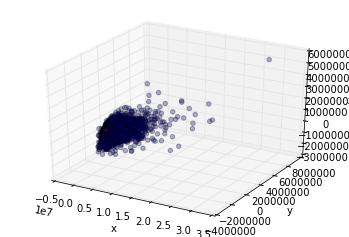

In [77]:
ax1 = graph_3d(X_pca_transformed, test_df)
ax.set_xlim(-5000000,20000000)
ax.set_ylim(-1000000,8000000)
ax.set_zlim(-3000000,3000000)
plt.show()

In [68]:
mask = test_df['indicted']==True

In [73]:
X_pca_masked = X_pca_transformed[mask]
test_df_masked = test_df[mask]

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


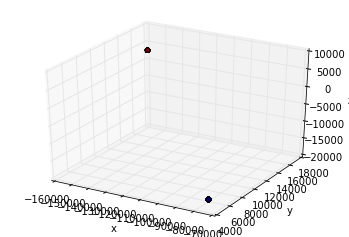

In [76]:
xs = X_pca_masked[:,0]
ys = X_pca_masked[:,1]
zs = X_pca_masked[:,2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_xlim(-5000000,20000000)
#ax.set_ylim(-1000000,8000000)
#ax.set_zlim(-3000000,3000000)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(xs, ys, zs, c=c, alpha=.3)
plt.show()

In [30]:
import plotly.plotly as py
from plotly.graph_objs import *
# auto sign-in with credentials or use py.sign_in()
trace1 = Scatter3d(
        x=xs,
        y=ys,
        z=zs
    )
data = Data([trace1])
py.plot(data)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/plotly/plotly/plotly.py:236: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



PlotlyLocalCredentialsError: 
Couldn't find a 'username', 'api-key' pair for you on your local machine. To sign in temporarily (until you stop running Python), run:
>>> import plotly.plotly as py
>>> py.sign_in('username', 'api_key')

Even better, save your credentials permanently using the 'tools' module:
>>> import plotly.tools as tls
>>> tls.set_credentials_file(username='username', api_key='api-key')

For more help, see https://plot.ly/python.
